<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_for_odd_sized_images_ver15%20int%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
#os._exit(0)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,28,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_data5656():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

(60000, 28, 28)
(10000, 28, 56)


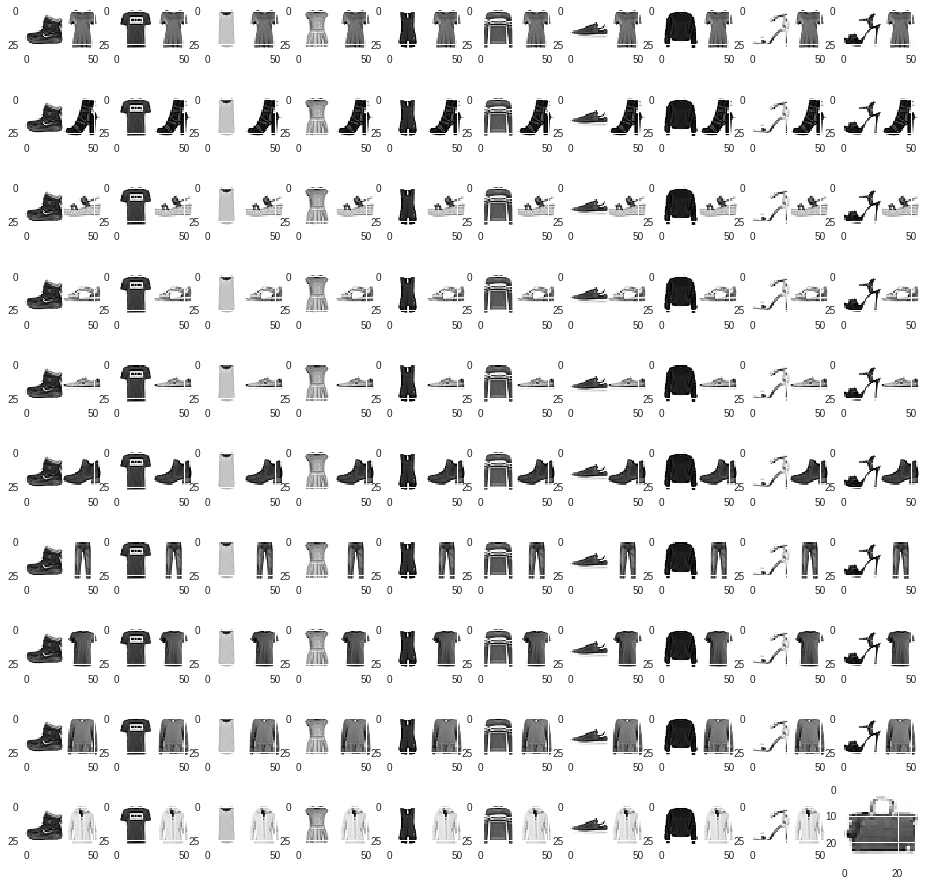

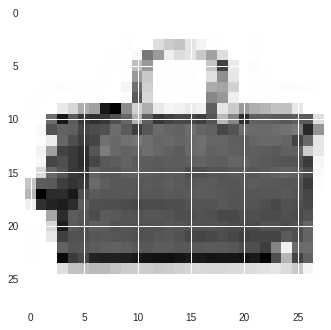

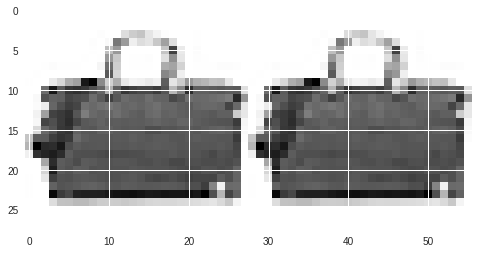

In [8]:
X_trainlarge = load_large_data()

(60000, 28, 28)
(10000, 56, 56)


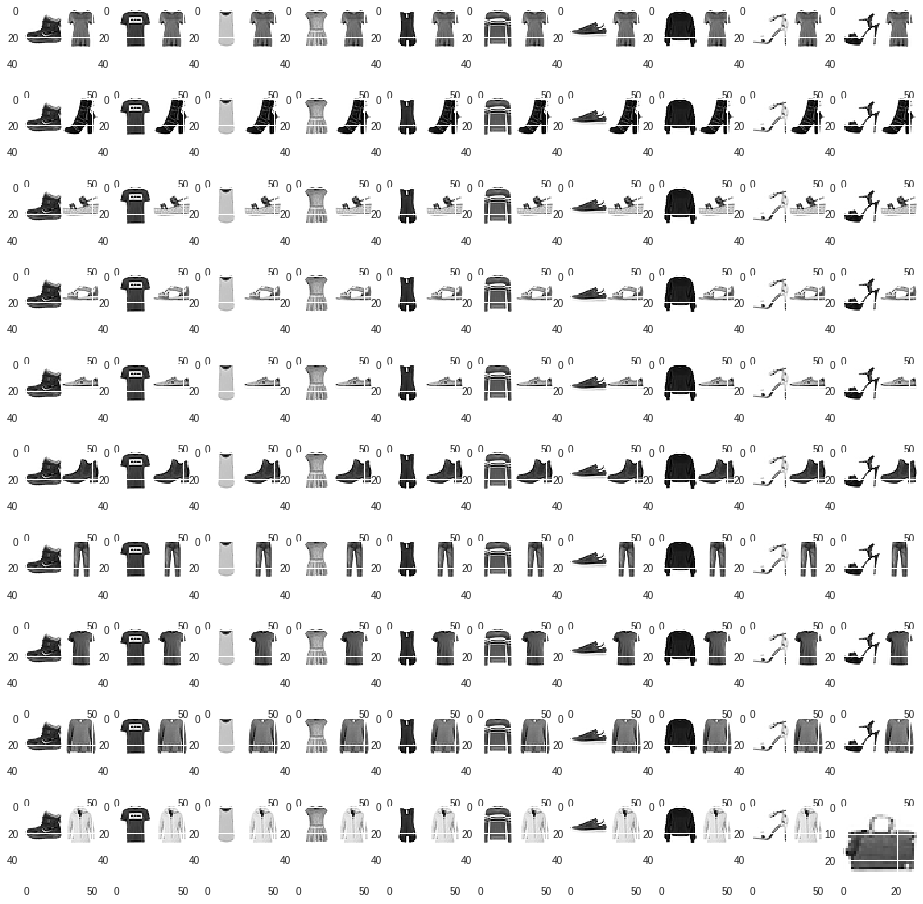

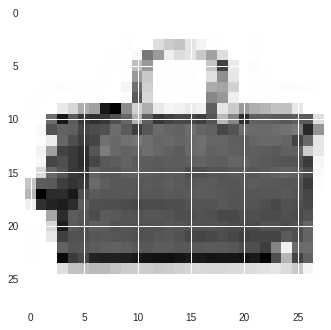

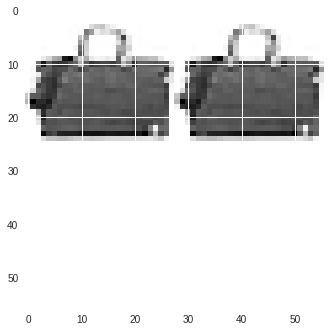

In [9]:
X_trainlarge5656 = load_large_data5656()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  if (datasetname == 3):   
     X_train = X_trainlarge
  if (datasetname == 4):   
     X_train = X_trainlarge5656

  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
  #  print("-- Discriminator -- ")
   # model.summary()
    return model

In [0]:
def build_discriminator2856(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    #Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
   # Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)
    X_train5656 = None
    
    if modeltotrain == 3:
          X_train5656 = load_databydatasetname(3)

    num_examples = X_train.shape[0] / 10
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
        
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              noise2 = copy.deepcopy(noise1)
              fake_images3 = mergedmodel.predict(noise2)
              fake_labels3 = np.zeros((half_batch, 1))    
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            X_train = X_trainlarge
            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)            
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNandriNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 56, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    for obj1 in outputs:
      print(type(obj1))
      print(obj1.shape)
        
    mergedlayer = Concatenate(axis=2)(outputs)
    ##x = merge([lstm_out, auxiliary_input], mode='concat')
   ## output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
  #  mergedlayer = merge([generator1, generator2], mode='concat', concat_axis=1)
  
   #mergedlayer = merge([out1, out], mode='concat', concat_axis=1)
#contact axis can be -1 to 0 , 1 for inception , 2 , 3 or remove it
  #  mergedlayer = merge([generator1, generator1])

    print('merge layers')
    print(out1.shape)
    print(out.shape)
    print(mergedlayer.shape)

  

    
    
    mergedmodel = Model(z, mergedlayer)
    
    discriminator.trainable = False
    real = discriminator(mergedlayer)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
      generator1.load_weights('my_model_weights_mnist.h5')
      generator2.load_weights('my_model_weights_mnist.h5')
      #generator1 = load_model('generator2fmnist.h5')
      #generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    plotamodel(mergedmodel)
   # plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [32]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 1 ,  loadpretrainedweights=True)




    
    

    


<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
merge layers
(?, 28, 28, 1)
(?, 28, 28, 1)
(?, 28, 56, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 7, 7, 128)    0           dense_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 

In [24]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5

--2018-12-06 11:08:00--  https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rajagopalmotivate/try1/master/my_model_weights_mnist.h5 [following]
--2018-12-06 11:08:01--  https://raw.githubusercontent.com/rajagopalmotivate/try1/master/my_model_weights_mnist.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3460672 (3.3M) [application/octet-stream]
Saving to: ‘my_model_weights_mnist.h5’

my_model_weights_mn 100%[===================>]   3.30M  --.-KB/s    in 0.1s    

2018-12-06 11:08:03 (32.4 MB/s) - ‘my_mod

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
plotamodel(discriminator)
files.download('model.png')




In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=10, modeltotrain=1)

Number of examples:  6000.0
Number of Batches:  187
Number of epochs:  1
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 56, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/187 [D loss: 0.877239, acc.: 46.88%] [G loss: 0.565405]


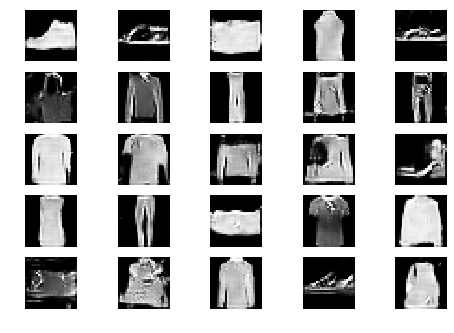

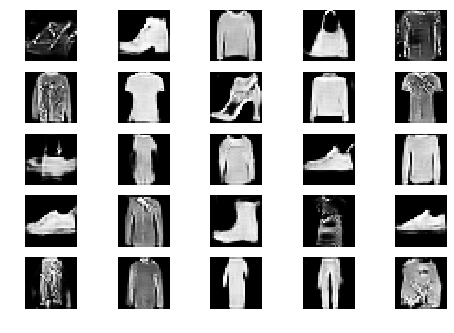

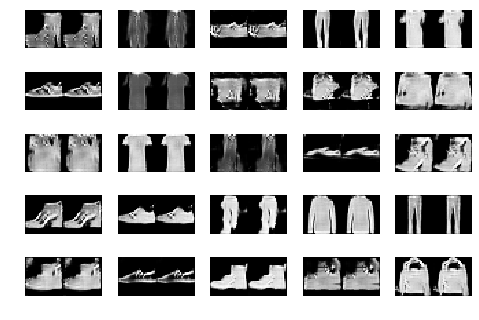

Epoch 0 Batch 1/187 [D loss: 0.807448, acc.: 53.12%] [G loss: 0.721946]
Epoch 0 Batch 2/187 [D loss: 0.777079, acc.: 56.25%] [G loss: 0.781984]
Epoch 0 Batch 3/187 [D loss: 0.735482, acc.: 53.12%] [G loss: 0.946872]
Epoch 0 Batch 4/187 [D loss: 0.888443, acc.: 31.25%] [G loss: 0.719828]
Epoch 0 Batch 5/187 [D loss: 0.934147, acc.: 31.25%] [G loss: 0.783142]
Epoch 0 Batch 6/187 [D loss: 0.872032, acc.: 46.88%] [G loss: 0.837726]
Epoch 0 Batch 7/187 [D loss: 0.746883, acc.: 46.88%] [G loss: 0.822787]
Epoch 0 Batch 8/187 [D loss: 0.827379, acc.: 40.62%] [G loss: 0.766110]
Epoch 0 Batch 9/187 [D loss: 0.866696, acc.: 56.25%] [G loss: 0.929645]
Epoch 0 Batch 10/187 [D loss: 0.815605, acc.: 40.62%] [G loss: 1.048790]
Epoch 0 Batch 11/187 [D loss: 0.782884, acc.: 62.50%] [G loss: 0.934527]
Epoch 0 Batch 12/187 [D loss: 0.903800, acc.: 40.62%] [G loss: 0.994713]
Epoch 0 Batch 13/187 [D loss: 0.807572, acc.: 46.88%] [G loss: 0.811245]
Epoch 0 Batch 14/187 [D loss: 0.778295, acc.: 50.00%] [G los

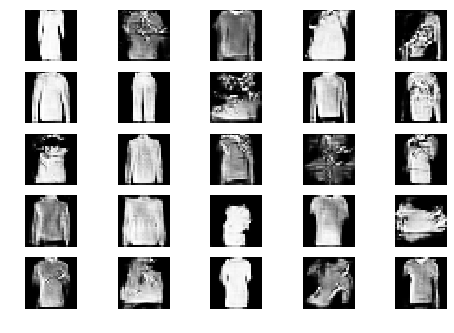

Epoch 0 Batch 101/187 [D loss: 0.923703, acc.: 56.25%] [G loss: 0.985818]


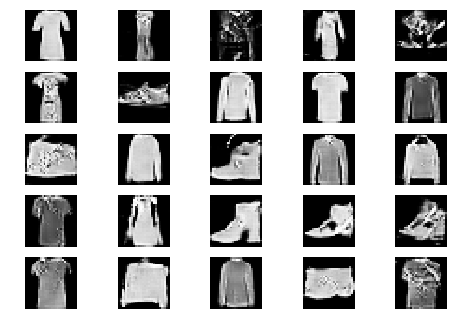

Epoch 0 Batch 102/187 [D loss: 0.825836, acc.: 50.00%] [G loss: 0.866860]


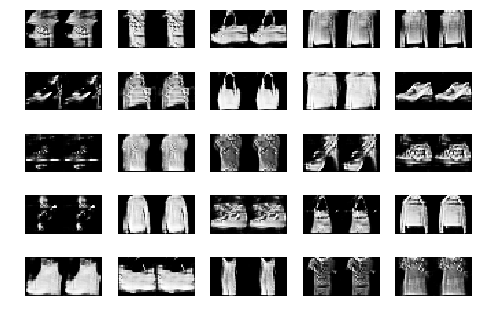

Epoch 0 Batch 103/187 [D loss: 0.764341, acc.: 56.25%] [G loss: 1.020661]
Epoch 0 Batch 104/187 [D loss: 0.921346, acc.: 40.62%] [G loss: 0.852113]
Epoch 0 Batch 105/187 [D loss: 0.911300, acc.: 53.12%] [G loss: 0.868193]
Epoch 0 Batch 106/187 [D loss: 0.833486, acc.: 50.00%] [G loss: 0.898901]
Epoch 0 Batch 107/187 [D loss: 0.823729, acc.: 43.75%] [G loss: 0.974408]
Epoch 0 Batch 108/187 [D loss: 0.840577, acc.: 43.75%] [G loss: 1.063208]
Epoch 0 Batch 109/187 [D loss: 0.802349, acc.: 46.88%] [G loss: 1.180792]
Epoch 0 Batch 110/187 [D loss: 0.669774, acc.: 53.12%] [G loss: 1.028833]
Epoch 0 Batch 111/187 [D loss: 0.761609, acc.: 50.00%] [G loss: 0.973091]
Epoch 0 Batch 112/187 [D loss: 0.692423, acc.: 75.00%] [G loss: 1.044545]
Epoch 0 Batch 113/187 [D loss: 0.784676, acc.: 50.00%] [G loss: 0.958860]
Epoch 0 Batch 114/187 [D loss: 0.639367, acc.: 62.50%] [G loss: 0.927656]
Epoch 0 Batch 115/187 [D loss: 0.857485, acc.: 59.38%] [G loss: 1.174616]
Epoch 0 Batch 116/187 [D loss: 1.07627

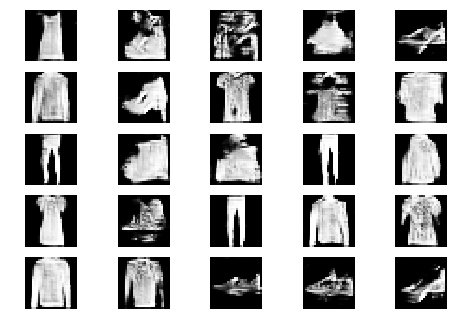

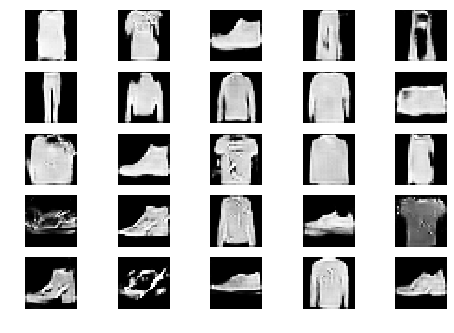

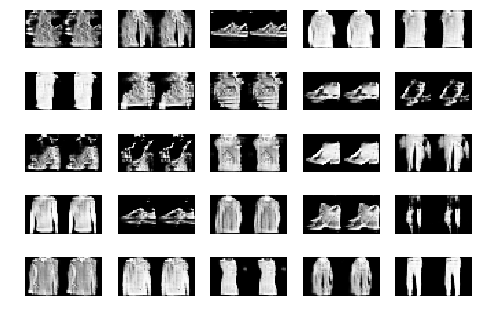

Epoch 1 Batch 1/187 [D loss: 0.917219, acc.: 34.38%] [G loss: 0.758625]
Epoch 1 Batch 2/187 [D loss: 0.611813, acc.: 65.62%] [G loss: 0.989756]
Epoch 1 Batch 3/187 [D loss: 0.746575, acc.: 56.25%] [G loss: 0.907670]
Epoch 1 Batch 4/187 [D loss: 0.680360, acc.: 59.38%] [G loss: 0.891453]
Epoch 1 Batch 5/187 [D loss: 0.766014, acc.: 59.38%] [G loss: 1.335581]
Epoch 1 Batch 6/187 [D loss: 0.683775, acc.: 59.38%] [G loss: 1.313675]
Epoch 1 Batch 7/187 [D loss: 0.689107, acc.: 62.50%] [G loss: 1.228980]
Epoch 1 Batch 8/187 [D loss: 0.687528, acc.: 59.38%] [G loss: 1.136312]
Epoch 1 Batch 9/187 [D loss: 0.825614, acc.: 46.88%] [G loss: 1.408540]
Epoch 1 Batch 10/187 [D loss: 0.664188, acc.: 59.38%] [G loss: 1.336090]
Epoch 1 Batch 11/187 [D loss: 0.752363, acc.: 62.50%] [G loss: 1.281298]
Epoch 1 Batch 12/187 [D loss: 0.652919, acc.: 53.12%] [G loss: 1.192231]
Epoch 1 Batch 13/187 [D loss: 0.766928, acc.: 56.25%] [G loss: 0.934122]
Epoch 1 Batch 14/187 [D loss: 0.807563, acc.: 53.12%] [G los

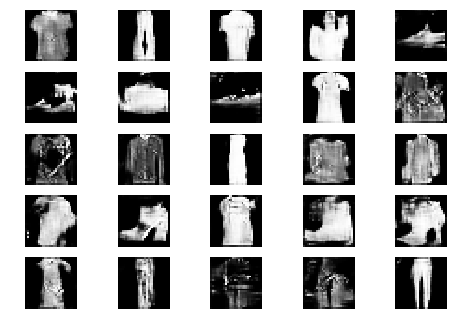

Epoch 1 Batch 101/187 [D loss: 0.788409, acc.: 46.88%] [G loss: 1.031422]


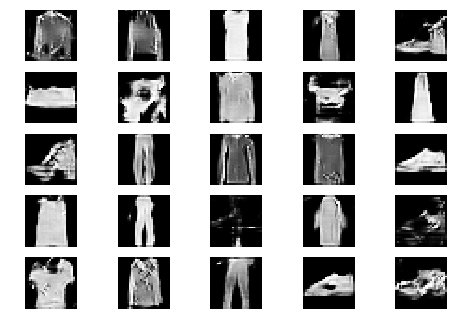

Epoch 1 Batch 102/187 [D loss: 0.725920, acc.: 50.00%] [G loss: 1.494603]


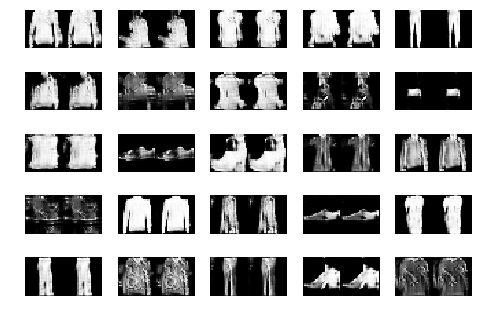

Epoch 1 Batch 103/187 [D loss: 0.609727, acc.: 65.62%] [G loss: 1.270678]
Epoch 1 Batch 104/187 [D loss: 0.711876, acc.: 56.25%] [G loss: 1.097707]
Epoch 1 Batch 105/187 [D loss: 0.677122, acc.: 68.75%] [G loss: 0.979249]
Epoch 1 Batch 106/187 [D loss: 0.707272, acc.: 59.38%] [G loss: 1.112923]
Epoch 1 Batch 107/187 [D loss: 0.661332, acc.: 59.38%] [G loss: 0.966295]
Epoch 1 Batch 108/187 [D loss: 0.593838, acc.: 65.62%] [G loss: 0.824408]
Epoch 1 Batch 109/187 [D loss: 0.649814, acc.: 65.62%] [G loss: 0.930310]
Epoch 1 Batch 110/187 [D loss: 0.647447, acc.: 59.38%] [G loss: 1.127006]
Epoch 1 Batch 111/187 [D loss: 0.663847, acc.: 56.25%] [G loss: 1.178562]
Epoch 1 Batch 112/187 [D loss: 0.660099, acc.: 65.62%] [G loss: 1.186453]
Epoch 1 Batch 113/187 [D loss: 0.776784, acc.: 62.50%] [G loss: 0.754020]
Epoch 1 Batch 114/187 [D loss: 0.747481, acc.: 53.12%] [G loss: 1.062265]
Epoch 1 Batch 115/187 [D loss: 0.823062, acc.: 34.38%] [G loss: 0.904318]
Epoch 1 Batch 116/187 [D loss: 0.72899

In [33]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=10, modeltotrain = 3)

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 2 ,  loadpretrainedweights=True)




    
    

    


Number of examples:  6000.0
Number of Batches:  187
Number of epochs:  1
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 56, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/187 [D loss: 1.220273, acc.: 34.38%] [G loss: 0.451063]


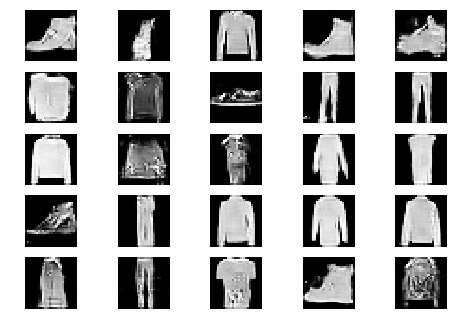

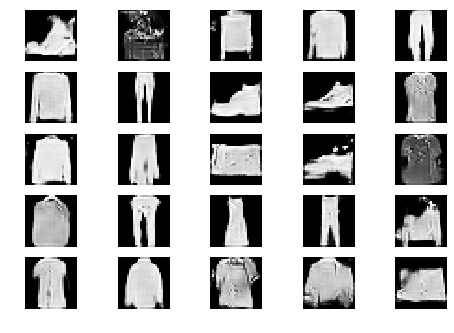

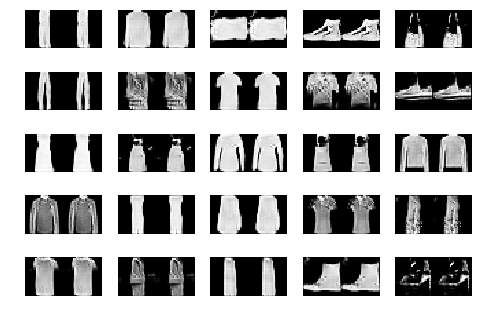

Epoch 0 Batch 1/187 [D loss: 0.883984, acc.: 50.00%] [G loss: 0.648805]
Epoch 0 Batch 2/187 [D loss: 0.864274, acc.: 34.38%] [G loss: 0.676403]
Epoch 0 Batch 3/187 [D loss: 0.854367, acc.: 53.12%] [G loss: 0.867898]
Epoch 0 Batch 4/187 [D loss: 0.836581, acc.: 37.50%] [G loss: 0.934017]
Epoch 0 Batch 5/187 [D loss: 0.842354, acc.: 37.50%] [G loss: 1.088172]
Epoch 0 Batch 6/187 [D loss: 0.829845, acc.: 43.75%] [G loss: 0.901595]
Epoch 0 Batch 7/187 [D loss: 0.790864, acc.: 50.00%] [G loss: 0.741150]
Epoch 0 Batch 8/187 [D loss: 0.714698, acc.: 40.62%] [G loss: 0.948346]
Epoch 0 Batch 9/187 [D loss: 1.000303, acc.: 34.38%] [G loss: 0.926703]
Epoch 0 Batch 10/187 [D loss: 0.634060, acc.: 59.38%] [G loss: 0.847172]
Epoch 0 Batch 11/187 [D loss: 0.906613, acc.: 34.38%] [G loss: 0.909614]
Epoch 0 Batch 12/187 [D loss: 0.843404, acc.: 53.12%] [G loss: 0.770108]
Epoch 0 Batch 13/187 [D loss: 0.892355, acc.: 40.62%] [G loss: 0.699057]
Epoch 0 Batch 14/187 [D loss: 0.662002, acc.: 56.25%] [G los

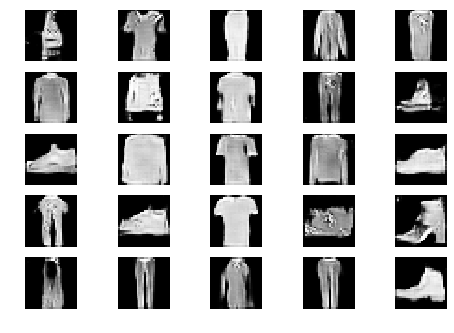

Epoch 0 Batch 101/187 [D loss: 0.804580, acc.: 53.12%] [G loss: 0.634052]


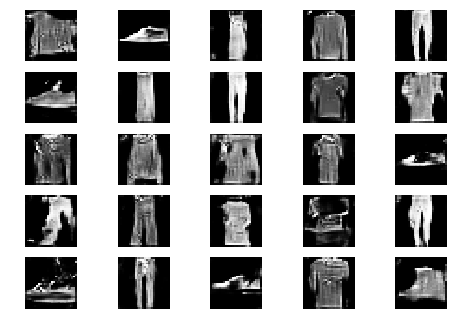

Epoch 0 Batch 102/187 [D loss: 0.815711, acc.: 43.75%] [G loss: 0.822082]


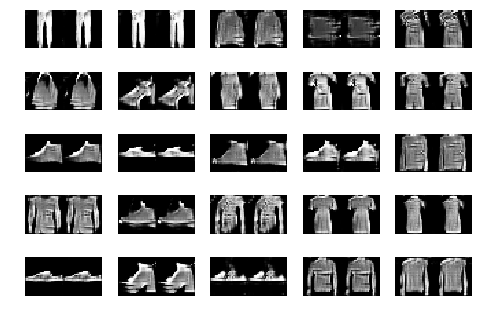

Epoch 0 Batch 103/187 [D loss: 0.966907, acc.: 40.62%] [G loss: 0.841384]
Epoch 0 Batch 104/187 [D loss: 0.825908, acc.: 53.12%] [G loss: 1.137937]
Epoch 0 Batch 105/187 [D loss: 0.662011, acc.: 62.50%] [G loss: 0.922763]
Epoch 0 Batch 106/187 [D loss: 0.820263, acc.: 50.00%] [G loss: 0.893978]
Epoch 0 Batch 107/187 [D loss: 0.720992, acc.: 53.12%] [G loss: 0.958471]
Epoch 0 Batch 108/187 [D loss: 0.595066, acc.: 62.50%] [G loss: 1.053897]
Epoch 0 Batch 109/187 [D loss: 0.772048, acc.: 46.88%] [G loss: 0.997019]
Epoch 0 Batch 110/187 [D loss: 0.707530, acc.: 53.12%] [G loss: 0.966208]
Epoch 0 Batch 111/187 [D loss: 0.729008, acc.: 53.12%] [G loss: 1.020847]
Epoch 0 Batch 112/187 [D loss: 0.634940, acc.: 68.75%] [G loss: 1.101542]
Epoch 0 Batch 113/187 [D loss: 0.715873, acc.: 65.62%] [G loss: 0.969619]
Epoch 0 Batch 114/187 [D loss: 1.144693, acc.: 28.12%] [G loss: 1.046546]
Epoch 0 Batch 115/187 [D loss: 0.776468, acc.: 46.88%] [G loss: 1.086950]
Epoch 0 Batch 116/187 [D loss: 0.85773

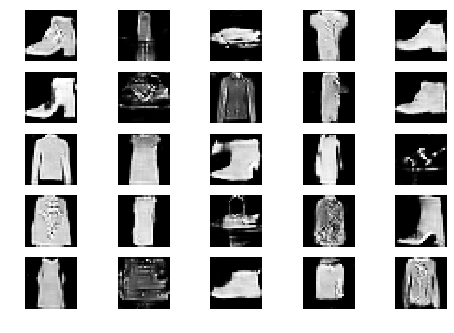

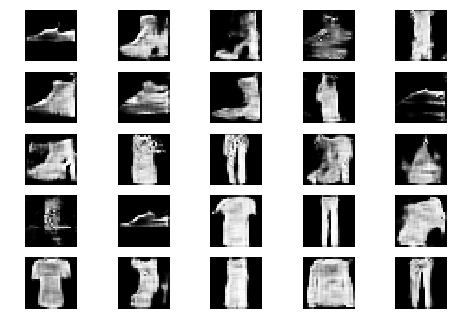

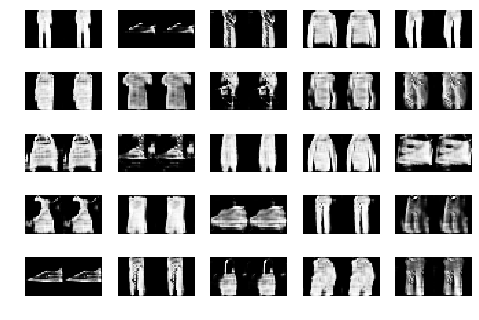

Epoch 1 Batch 1/187 [D loss: 0.817103, acc.: 53.12%] [G loss: 1.103990]
Epoch 1 Batch 2/187 [D loss: 0.595128, acc.: 59.38%] [G loss: 1.170909]
Epoch 1 Batch 3/187 [D loss: 0.606033, acc.: 59.38%] [G loss: 1.178575]
Epoch 1 Batch 4/187 [D loss: 0.736643, acc.: 53.12%] [G loss: 1.128572]
Epoch 1 Batch 5/187 [D loss: 0.826582, acc.: 37.50%] [G loss: 1.146378]
Epoch 1 Batch 6/187 [D loss: 0.560601, acc.: 78.12%] [G loss: 1.167411]
Epoch 1 Batch 7/187 [D loss: 0.809899, acc.: 53.12%] [G loss: 1.034214]
Epoch 1 Batch 8/187 [D loss: 0.665653, acc.: 53.12%] [G loss: 0.906003]
Epoch 1 Batch 9/187 [D loss: 0.623969, acc.: 59.38%] [G loss: 0.941452]
Epoch 1 Batch 10/187 [D loss: 0.723629, acc.: 53.12%] [G loss: 1.249124]
Epoch 1 Batch 11/187 [D loss: 0.672334, acc.: 59.38%] [G loss: 0.931682]
Epoch 1 Batch 12/187 [D loss: 0.707416, acc.: 56.25%] [G loss: 1.016503]
Epoch 1 Batch 13/187 [D loss: 0.668294, acc.: 59.38%] [G loss: 1.234151]
Epoch 1 Batch 14/187 [D loss: 0.746907, acc.: 53.12%] [G los

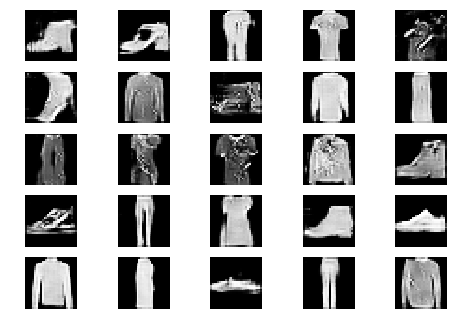

Epoch 1 Batch 101/187 [D loss: 0.791755, acc.: 50.00%] [G loss: 0.973313]


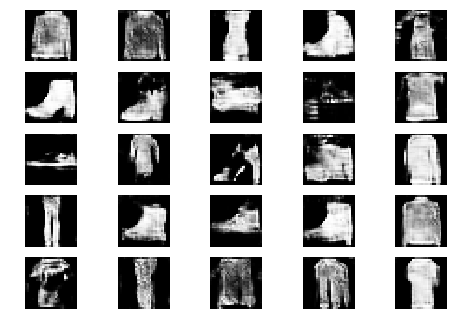

Epoch 1 Batch 102/187 [D loss: 0.524923, acc.: 71.88%] [G loss: 0.939769]


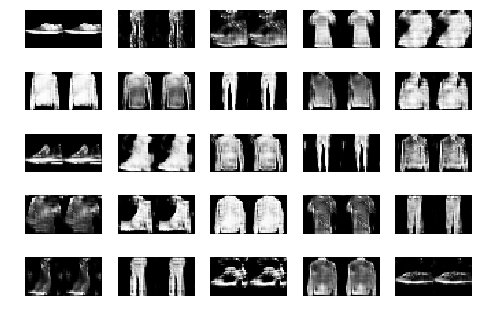

Epoch 1 Batch 103/187 [D loss: 0.878457, acc.: 46.88%] [G loss: 0.743219]
Epoch 1 Batch 104/187 [D loss: 0.578861, acc.: 68.75%] [G loss: 1.018955]
Epoch 1 Batch 105/187 [D loss: 0.586857, acc.: 68.75%] [G loss: 0.995265]
Epoch 1 Batch 106/187 [D loss: 0.780353, acc.: 53.12%] [G loss: 0.887877]
Epoch 1 Batch 107/187 [D loss: 0.643105, acc.: 62.50%] [G loss: 1.034807]
Epoch 1 Batch 108/187 [D loss: 0.587413, acc.: 71.88%] [G loss: 0.946392]
Epoch 1 Batch 109/187 [D loss: 0.813591, acc.: 43.75%] [G loss: 0.935367]
Epoch 1 Batch 110/187 [D loss: 0.673929, acc.: 62.50%] [G loss: 1.088238]
Epoch 1 Batch 111/187 [D loss: 0.801477, acc.: 50.00%] [G loss: 1.083583]
Epoch 1 Batch 112/187 [D loss: 0.563938, acc.: 59.38%] [G loss: 0.997921]
Epoch 1 Batch 113/187 [D loss: 0.716002, acc.: 59.38%] [G loss: 1.011573]
Epoch 1 Batch 114/187 [D loss: 0.861740, acc.: 43.75%] [G loss: 0.800479]
Epoch 1 Batch 115/187 [D loss: 0.649162, acc.: 59.38%] [G loss: 1.202507]
Epoch 1 Batch 116/187 [D loss: 0.66786

In [35]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=20, modeltotrain=3)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5
!rm -rf generator2fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator2fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')


In [0]:
generator2 = generator2.load_weights('generator1fminst.h5')




In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

